In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree

# Local
import util
import utils
import pickle

In [2]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 400

# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [3]:
masks = ['gaia_mask', 'SGA_parent', 'clusters']
tracers = ['BG', 'LRG']

In [4]:
BG_densities = {}
LRG_densities = {}

In [5]:
for mask in masks:
    BG_densities[mask] = pickle.load(open(f'{mask}_BG_densities.pkl', 'rb'))    
    LRG_densities[mask] = pickle.load(open(f'{mask}_LRG_densities.pkl', 'rb'))

In [6]:
densities = [BG_densities, LRG_densities]

### NGC clusters

In [7]:
# --- your existing bins & setup ---
mag_bins = [(8, 12), (12, 13), (13, 15), (15, 16)]
nbins    = 600
r_extent = 60
annulus  = (1, 60.0)
dr       = 0.1

# --- placeholder functions: replace with the real DR8/DR9 formulas ---
def mask_radius_DR9(g):
    # DR9 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. piecewise interpolation from Legacy Surveys DR9 prescription.
    # Here’s a toy example:
    return  10**(0.2*(13 - g))

def mask_radius_DR8(g):
    # DR8 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. a different piecewise curve published for DR8.
    # Here’s a toy example that’s ~1.7× larger than DR9:
    return 2 * mask_radius_DR9(g)

def mask_radius_for_mag(mag):
    # Returns a masking radius in degrees for a star of the given magnitude.
    # Used for Tycho-2 and Gaia stars.

    # This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].
    return 0.5*1630. * 1.396**(-mag)


In [8]:
color_map = ['PuBuGn', 'OrRd']

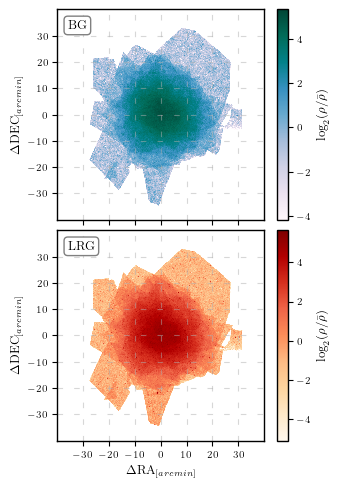

In [11]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=False, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.05, wspace=0.01)

for i, ax in enumerate(axes):
    tracer = tracers[i]
    tracer_density = densities[i]['clusters']

    R_BS = tracer_density['R_BS']
    x = tracer_density['x']
    y = tracer_density['y']

    H, xe, ye = tracer_density['H'], tracer_density['xe'], tracer_density['ye']
    Xc, Yc = tracer_density['Xc'], tracer_density['Yc']
    XX, YY = tracer_density['XX'], tracer_density['YY']
    R = np.sqrt(XX**2 + YY**2)
    mask = (R > annulus[0]) & (R < annulus[1])
    eta_mean = tracer_density['eta_mean']
    density_ratio = tracer_density['density_ratio']
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T, cmap=color_map[i])
    ax.grid(linestyle=(0, (5, 10)), alpha=0.5)
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.xaxis.set_ticks(np.arange(-30, 40, 10))
    ax.yaxis.set_ticks(np.arange(-30, 40, 10))

    if i == 1:
        ax.set_xlabel(r'$\Delta\mathrm{RA}_{[arc min]}$')
    # if i == 0:
    ax.set_ylabel(r'$\Delta\mathrm{DEC}_{[arc min]}$')
    ax.text(
        0.05, 0.95, tracer,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=MEDIUM_SIZE,
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    # if i == 1:
    fig.colorbar(pcm, ax=ax, orientation='vertical', label=r'$\log_2(\rho/\bar\rho)$')
    # else:
    #     fig.colorbar(pcm, ax=ax, orientation='vertical')
# cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

# plt.tight_layout( h_pad=0.1, w_pad=1)
# plt.savefig('NGC_star_cluster_mask_both_2x1.png', dpi=450,bbox_inches='tight')
plt.savefig('NGC_star_cluster_both_2x1.pdf', dpi=450, bbox_inches='tight')
plt.show()


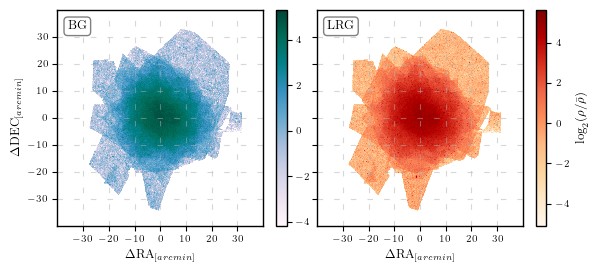

In [12]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, sharex=False, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.05, wspace=0.01)

for i, ax in enumerate(axes):
    tracer = tracers[i]
    tracer_density = densities[i]['clusters']

    R_BS = tracer_density['R_BS']
    x = tracer_density['x']
    y = tracer_density['y']

    H, xe, ye = tracer_density['H'], tracer_density['xe'], tracer_density['ye']
    Xc, Yc = tracer_density['Xc'], tracer_density['Yc']
    XX, YY = tracer_density['XX'], tracer_density['YY']
    R = np.sqrt(XX**2 + YY**2)
    mask = (R > annulus[0]) & (R < annulus[1])
    eta_mean = tracer_density['eta_mean']
    density_ratio = tracer_density['density_ratio']
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T, cmap=color_map[i])
    ax.grid(linestyle=(0, (5, 10)), alpha=0.5)
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.xaxis.set_ticks(np.arange(-30, 40, 10))
    ax.yaxis.set_ticks(np.arange(-30, 40, 10))

    # if i == 1:
    ax.set_xlabel(r'$\Delta\mathrm{RA}_{[arc min]}$')
    if i == 0:
        ax.set_ylabel(r'$\Delta\mathrm{DEC}_{[arc min]}$')
    ax.text(
        0.05, 0.95, tracer,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=MEDIUM_SIZE,
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    if i == 1:
        fig.colorbar(pcm, ax=ax, orientation='vertical', label=r'$\log_2(\rho/\bar\rho)$')
    else:
        fig.colorbar(pcm, ax=ax, orientation='vertical')
# cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

# plt.tight_layout( h_pad=0.1, w_pad=1)
# plt.savefig('NGC_star_cluster_mask_both_1x2.png', dpi=450,bbox_inches='tight')
plt.savefig('NGC_star_cluster_mask_both_1x2.pdf', dpi=450, bbox_inches='tight')
plt.show()
